# Evaluation of GPT-2 models with FHE-compliant operators 

This notebook presents a first approach of how to execute a GPT model in FHE, where some specific parts of the model are converted to FHE computations.
In the following, we consider the GPT-2 model with the language modeling head on top, with the following configuration: 12 layers, 12 attention heads, 768 embedding dimensions and a vocabulary size of 50257 words.
Additionally, our QGPT-2 models are built around Hugging Face's Transformer library, sharing the same API with only a few additional steps to acknowledge.

We therefore evaluate the performance of two quantized versions of the GPT-2 model:
- a model that quantizes a single attention head found in the first layer: SingleHeadQGPT2Model
- a model that quantizes a complete multi-head attention pass found in the first layer: MultiHeadsQGPT2Model

The quantized operators from these models are FHE-compliant, meaning that these specific part can be executed in FHE, while the rest of the model are done in float in the clear.
We therefore explain how to load these models from the Hugging Face's associated pre-trained ones, calibrate them, compile their FHE circuit and then execute their inference with some FHE.
Finally, we compare different top-k accuracies on the next token predicted from a base text for both models with respect to the number of bits of quantization used. Using these figures, we show that inputs and weights can be quantized over less than 8 bits to make the inference reach near-floating point performances.


### Imports and loads

In [1]:
import sys
import os
import torch
from logging import getLogger, ERROR

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Fix module imports
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Disable Hugging Face warnings
getLogger("transformers.modeling_utils").setLevel(ERROR)

We load the GPT-2 model (GPT2LMHeadModel) and tokenizer.

In [2]:
from model.qgpt2_models import MultiHeadsQGPT2Model, SingleHeadQGPT2Model
from transformers.models.gpt2 import GPT2LMHeadModel, GPT2Tokenizer

gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")

/data/bz620/fyp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Performance Evaluation

In the following, we evaluate the impact of the number of bits used for quantization on the models' performance.
Here, we check for the top-k accuracies, with a few different values of k, on the predicted next logits with respected to the one computed by the initial floating point model.  

Model: SingleHeadQGPT2Model, n_bits: 2, Average Top-1 Accuracy: 0.7217
Model: SingleHeadQGPT2Model, n_bits: 3, Average Top-1 Accuracy: 0.7217
Model: SingleHeadQGPT2Model, n_bits: 4, Average Top-1 Accuracy: 0.9586
Model: SingleHeadQGPT2Model, n_bits: 5, Average Top-1 Accuracy: 0.9561
Model: SingleHeadQGPT2Model, n_bits: 6, Average Top-1 Accuracy: 0.9783
Model: SingleHeadQGPT2Model, n_bits: 7, Average Top-1 Accuracy: 0.9854
Model: SingleHeadQGPT2Model, n_bits: 8, Average Top-1 Accuracy: 0.9949
Model: SingleHeadQGPT2Model, n_bits: 9, Average Top-1 Accuracy: 0.9981
Model: SingleHeadQGPT2Model, n_bits: 10, Average Top-1 Accuracy: 0.9968
Model: SingleHeadQGPT2Model, n_bits: 11, Average Top-1 Accuracy: 0.9975
Model: SingleHeadQGPT2Model, n_bits: 2, Average Top-5 Accuracy: 0.9153
Model: SingleHeadQGPT2Model, n_bits: 3, Average Top-5 Accuracy: 0.9153
Model: SingleHeadQGPT2Model, n_bits: 4, Average Top-5 Accuracy: 0.9987
Model: SingleHeadQGPT2Model, n_bits: 5, Average Top-5 Accuracy: 0.9994
Mode

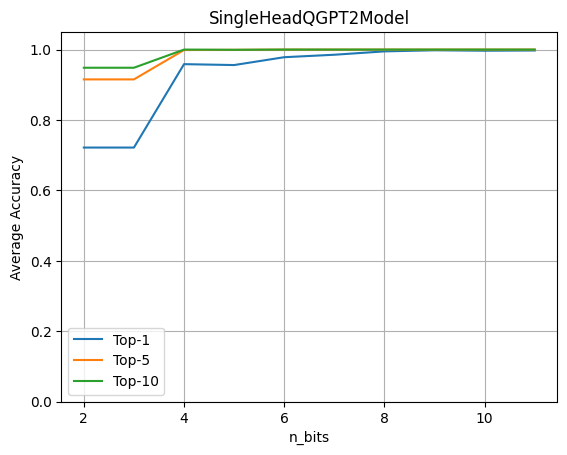

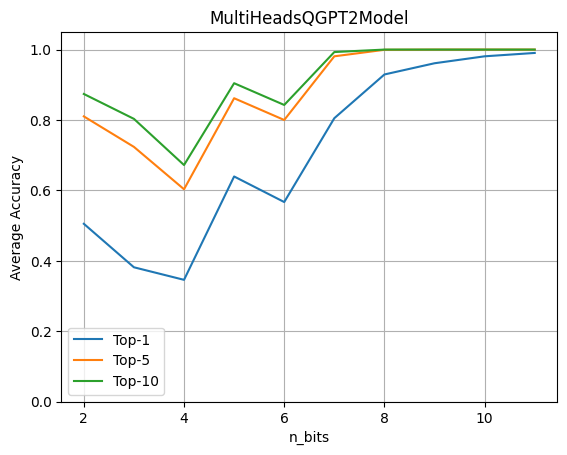

In [9]:
import matplotlib.pyplot as plt


%matplotlib inline

def generate_topk_tokens(model, tokenizer, text, top_k):
    """Generate the top-k tokens for every token in the text."""
    inputs = tokenizer.encode(text, return_tensors="pt")
    topk_tokens_list = []
    with torch.no_grad():
        outputs = model(inputs)
        logits = outputs.logits
        for logit in logits[0]:
            topk_tokens = torch.topk(
                logit,
                top_k,
            ).indices.tolist()
            topk_tokens_list.append(topk_tokens)
    return topk_tokens_list


def calculate_topk_accuracy(ground_truth_tokens, computed_tokens):
    """Calculate the top-k accuracy."""
    correct_count = sum([1 for gt_token in ground_truth_tokens if gt_token in computed_tokens])
    return correct_count / len(ground_truth_tokens)


# Define the models to evaluate
models = {
    "SingleHeadQGPT2Model": SingleHeadQGPT2Model,
    "MultiHeadsQGPT2Model": MultiHeadsQGPT2Model,
}

# Define the different number of bits and k values to evaluate
n_bits_range = list(range(2, 12))
top_ks = [1, 5, 10]

# Define the text data to use for the evaluation
dataset_file = "../data/data.txt"

# Read the evaluation file
with open(dataset_file, "r", encoding="utf-8") as file:
    input_texts = [line.strip() for line in file]

for model_name, Model in models.items():
    plt.figure()
    for top_k in top_ks:
        accuracies = []
        for n_bits in n_bits_range:

            # Load the model using the current number of bits and set it to clear quantized mode
            model = Model.from_pretrained(
                "gpt2",
                n_bits=n_bits,
            )
            model.set_fhe_mode(fhe="disable", true_float=False)

            accuracy_scores = []
            for text in input_texts:
                # Generate the top-k tokens for the Hugging Face floating point model
                hf_topk_tokens_list = generate_topk_tokens(gpt2_model, gpt2_tokenizer, text, 1)

                # Generate the top-k tokens for the clone model
                clone_topk_tokens_list = generate_topk_tokens(model, gpt2_tokenizer, text, top_k)

                # Compute the top-k accuracy for each token in the text
                for hf_topk_tokens, clone_topk_tokens in zip(
                    hf_topk_tokens_list, clone_topk_tokens_list
                ):
                    topk_accuracy = calculate_topk_accuracy(hf_topk_tokens, clone_topk_tokens)
                    accuracy_scores.append(topk_accuracy)

            # Compute the average accuracy within the text
            average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
            accuracies.append(average_accuracy)

            # Print the average accuracy for this model, n_bits, and top_k
            print(
                f"Model: {model_name}, "
                f"n_bits: {n_bits}, "
                f"Average Top-{top_k} Accuracy: {average_accuracy:.4f}"
            )

        plt.plot(n_bits_range, accuracies, label=f"Top-{top_k}")

    # Plot the model's evaluation
    plt.title(f"{model_name}")
    plt.xlabel("n_bits")
    plt.ylabel("Average Accuracy")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05)

plt.show()

We can see that for the first model, where only a single head if done with FHE-compliant operators, 4 bits are enough to recover 95\% of Hugging Face's performance in terms of top1 accuracy. 
For the second model, which implements a complete multi-head attention with quantized operators, 7 bits gives a 80\% exact predictions while the top-5 and top-10 accuracies reach 98\%.